# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import stats

In [2]:
%matplotlib inline
fig_width = 20
t_titre = 35/2
t_label = 25/2
colors = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']
from aSPEM import aSPEM
import bayesianchangepoint as bcp

In [3]:
liste = []
for fname in glob.glob('../data/*pkl'):
    a = fname.split('/')[2].split('.')[0].split('_')
    liste.append(a)
    #print(a)
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='bet' and liste[x][1] in ['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10','s11','s12'] :
        a = '../data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            b['oserver']=liste[x][1]
            exp.append(b)
param = []
for x in range(len(liste)) :
    if liste[x][0]=='bet' and liste[x][1] in ['s01','s02','s03','s04','s05','s06','s07','s08','s09','s10','s11','s12'] :
        a = 'parametre/test/param_Fit_%s.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)
print(len(colors)==len(param)==len(exp))

True


In [4]:
p_hat_bcp_e = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
p_hat_bcp_m = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

r_hat_bcp_e = [[],[],[],[],[],[],[],[],[],[],[],[],[]]
r_hat_bcp_m = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

for x in range(len(exp)):
        
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau
    
    p_hat_block_e = [[],[],[]]
    p_hat_block_m = [[],[],[]]

    r_hat_block_e = [[],[],[]]
    r_hat_block_m = [[],[],[]]
    
    for block in range(N_blocks):
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            #----------------------------------------------------
            p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=h, p0=.5)
            p_hat_e, r_hat_e = bcp.readout(p_bar, r, beliefs, mode='expectation')
            p_hat_m, r_hat_m = bcp.readout(p_bar, r, beliefs, mode='max')
            
            p_hat_block_e[block].extend(p_hat_e)
            p_hat_block_m[block].extend(p_hat_m)

            r_hat_block_e[block].extend(r_hat_e)
            r_hat_block_m[block].extend(r_hat_m)
            
    p_hat_bcp_e[x] = p_hat_block_e
    p_hat_bcp_m[x] = p_hat_block_m
    
    r_hat_bcp_e[x] = r_hat_block_e
    r_hat_bcp_m[x] = r_hat_block_m

In [5]:
# liste de tout
full_proba = []
full_bino = []
full_results = []
full_va = []
full_p_hat_e = []
full_p_hat_m = []
full_r_hat_e = []
full_r_hat_m = []

# listes de tout par sujet
proba_sujet = []
bino_sujet = []
results_sujet = []
va_sujet = []
p_hat_sujet_e = []
p_hat_sujet_m = []
r_hat_sujet_e = []
r_hat_sujet_m = []


for x in range(len(exp)):

    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    
    p = exp[x]['p']
    results = (exp[x]['results']+1)/2
    a_anti = param[x]['a_anti']
    p_hat_e = p_hat_bcp_e[x]
    p_hat_m = p_hat_bcp_m[x]
    r_hat_e = r_hat_bcp_e[x]
    r_hat_m = r_hat_bcp_m[x]
    
    liste_proba = []
    liste_bino = []
    liste_results = []
    liste_va = []
    liste_p_hat_e = []
    liste_p_hat_m = []
    liste_r_hat_e = []
    liste_r_hat_m = []
    
    for block in range(N_blocks):
                
        switch = []
        for s in range(N_trials):
            if s in [0,50,100,150] :
                switch.append(s)
            if p[s, block, 2]==1 :
                switch.append(s)
        switch.append(N_trials)
        
        for s1 in range(len(switch)-1) :

            for trial in np.arange(switch[s1], switch[s1+1]) :
                full_proba.append(p[trial, block, 1])
                full_bino.append(p[trial, block, 0])
                full_results.append(results[trial, block])
                full_va.append(a_anti[block][trial])

                liste_proba.append(p[trial, block, 1])
                liste_bino.append(p[trial, block, 0])
                liste_results.append(results[trial, block])
                liste_va.append(a_anti[block][trial])

                full_p_hat_e.append(p_hat_e[block][trial])
                full_p_hat_m.append(p_hat_m[block][trial])
                full_r_hat_e.append(r_hat_e[block][trial])
                full_r_hat_m.append(r_hat_m[block][trial])
                
                liste_p_hat_e.append(p_hat_e[block][trial])
                liste_p_hat_m.append(p_hat_m[block][trial])
                liste_r_hat_e.append(r_hat_e[block][trial])
                liste_r_hat_m.append(r_hat_m[block][trial])

    proba_sujet.append(liste_proba)
    bino_sujet.append(liste_bino)
    results_sujet.append(liste_results)
    va_sujet.append(liste_va)
    p_hat_sujet_e.append(liste_p_hat_e)
    p_hat_sujet_m.append(liste_p_hat_m)
    r_hat_sujet_e.append(liste_r_hat_e)
    r_hat_sujet_m.append(liste_r_hat_m)    

In [6]:
nb_sujet = len(proba_sujet)

## KDE

In [7]:
t_titre = 35/2
t_label = 25/2
fig_width= 15

In [8]:
# https://matthew-brett.github.io/teaching/mutual_information.html
def mutual_information(hgram):
    """ Mutual information for joint histogram"""
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

In [9]:
def figure(mode) :
    fig, axs = plt.subplots(6, 1, figsize=(fig_width, 1.5*fig_width/(1.6180)))
    #fig.subplots_adjust(left = 0, bottom = -1/2+(((len(sujet))*2/3)-0.16), right = 1, top =len(sujet))

    gs = gridspec.GridSpec(3, 2)
    gs.update(hspace=0.5, wspace=0.2)
    for x in range(6):
        axs[x] = plt.subplot(gs[x])

    ec = 0.2

    if mode=='expectation' :
        p_hat_sujet = p_hat_sujet_e
        full_p_hat = full_p_hat_e
    elif mode=='max' :
        p_hat_sujet = p_hat_sujet_m
        full_p_hat = full_p_hat_m
    
    for x, color in enumerate(colors[:nb_sujet]):
        axs[0].scatter(p_hat_sujet[x], results_sujet[x], c=color, alpha=0.5, linewidths=0)
        axs[1].scatter(p_hat_sujet[x], va_sujet[x], c=color, alpha=0.5, linewidths=0)
    
    x = full_p_hat
    y = full_results
    xmin, xmax =  np.min(x), np.max(x)
    ymin, ymax =  np.min(y), np.max(y)
    xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    axs[2].contourf(xx, yy, f, cmap='Greys')

    fmean = []
    for x in range(len(f)):
        fmean.append([])
        for y in range(len(f[x])):
            fmean[x].append(f[x][y]/np.sum(f[x]))
    
    axs[4].contourf(xx, yy, fmean, cmap='Greys')

    
    # masque les essais qui où full_va = NAN
    full_p_hat_nan = np.ma.masked_array(full_p_hat, mask=np.isnan(full_va)).compressed()
    full_va_nan = np.ma.masked_array(full_va, mask=np.isnan(full_va)).compressed()

    x = full_p_hat_nan
    y = full_va_nan
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    xx, yy = np.mgrid[xmin:xmax:300j, ymin:ymax:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    axs[3].contourf(xx, yy, f, cmap='Greys')
    
    fmean = []
    for x in range(len(f)):
        fmean.append([])
        for y in range(len(f[x])):
            fmean[x].append(f[x][y]/np.sum(f[x]))
    
    axs[5].contourf(xx, yy, fmean, cmap='Greys')

    
    for i_layer in range(len(axs)) :
        axs[i_layer].xaxis.set_ticks_position('bottom')
        axs[i_layer].yaxis.set_ticks_position('left')
        axs[i_layer].xaxis.set_tick_params(labelsize=t_label/1.8)
        axs[i_layer].yaxis.set_tick_params(labelsize=t_label/1.8)
        
        if i_layer in [0,2,4]:
            slope, intercept, r_, p_value, std_err = stats.linregress(full_p_hat, full_results)
            x_test = np.linspace(np.min(full_p_hat), np.max(full_p_hat), 100)
            fitLine = slope * x_test + intercept
            axs[i_layer].plot(x_test, fitLine, c='k', linewidth=2)
            axs[i_layer].text(0.75,-0.032+(1.032--0.032)/10, 'r = %0.3f'%(r_), fontsize=t_label/1.2)
            
            hist, x_edges, y_edges = np.histogram2d(full_p_hat,full_results,bins=20)
            axs[i_layer].text(0.75,-0.032+2*(1.032--0.032)/10, 'MI = %0.3f'%(mutual_information(hist)), fontsize=t_label/1.2)
            
            axs[i_layer].axis([-0.032, 1.032, -0.032, 1.032])
            axs[i_layer].set_ylabel('Probability Bet', fontsize=t_label/1.2)
            axs[i_layer].set_title("Probability Bet", fontsize=t_titre/1.2, x=0.5, y=1.05)
            axs[i_layer].set_xlabel('$\hat{P}_{%s}$'%(mode), fontsize=t_label/1) 
        
        elif i_layer in [1,3,5]:
            full_p_hat_nan = np.ma.masked_array(full_p_hat, mask=np.isnan(full_va)).compressed()
            full_va_nan = np.ma.masked_array(full_va, mask=np.isnan(full_va)).compressed()
            slope, intercept, r_value, p_value, std_err = stats.linregress(full_p_hat_nan, full_va_nan)
            x_test = np.linspace(np.min(full_p_hat), np.max(full_p_hat), 100)
            fitLine = slope * x_test + intercept
            axs[i_layer].plot(x_test, fitLine, c='k', linewidth=2)
            axs[i_layer].text(0.75,-21.28+(21.28--21.28)/10, 'r = %0.3f'%(r_value), fontsize=t_label/1.2)

            hist, x_edges, y_edges = np.histogram2d(full_p_hat_nan,full_va_nan,bins=20)
            axs[i_layer].text(0.75,-21.28+2*(21.28--21.28)/10, 'MI = %0.3f'%(mutual_information(hist)), fontsize=t_label/1.2)

            axs[i_layer].axis([-0.032, 1.032, -21.28, 21.28])
            axs[i_layer].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label/1.2)
            axs[i_layer].set_title("Acceleration", fontsize=t_titre/1.2, x=0.5, y=1.05)
            axs[i_layer].set_xlabel('$\hat{P}_{%s}$'%(mode), fontsize=t_label/1)   

    plt.show()

- fig 1 = scatter plot
- fig 2 = kde
- fig 3 = kde moyenné

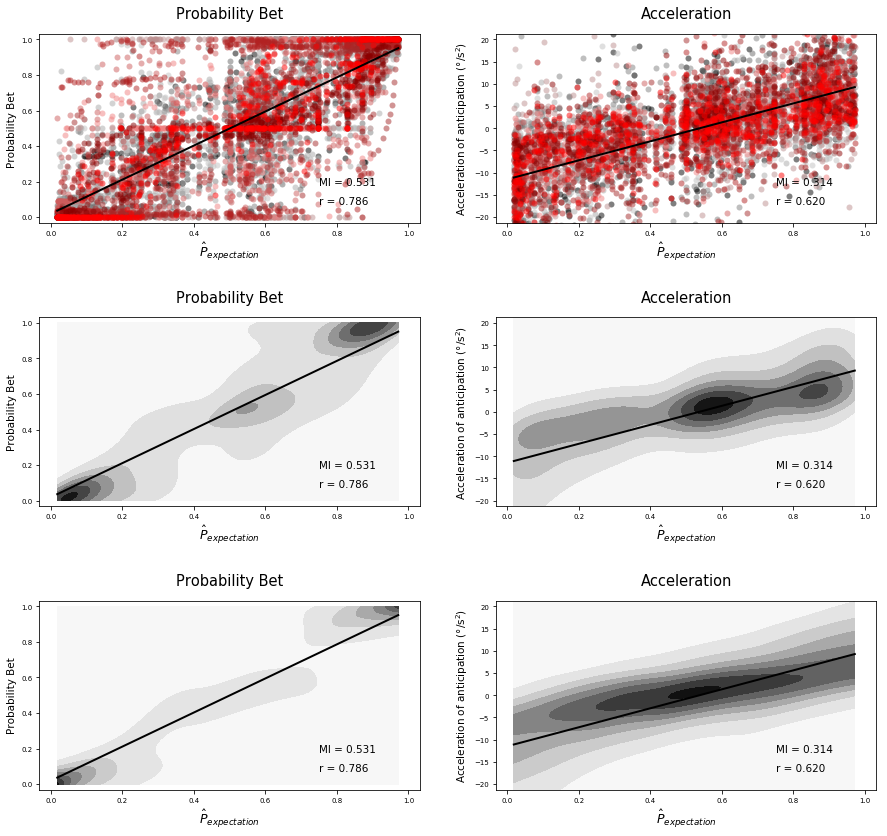

In [10]:
figure(mode='expectation')

- fig 1 = scatter plot
- fig 2 = kde
- fig 3 = kde moyenné

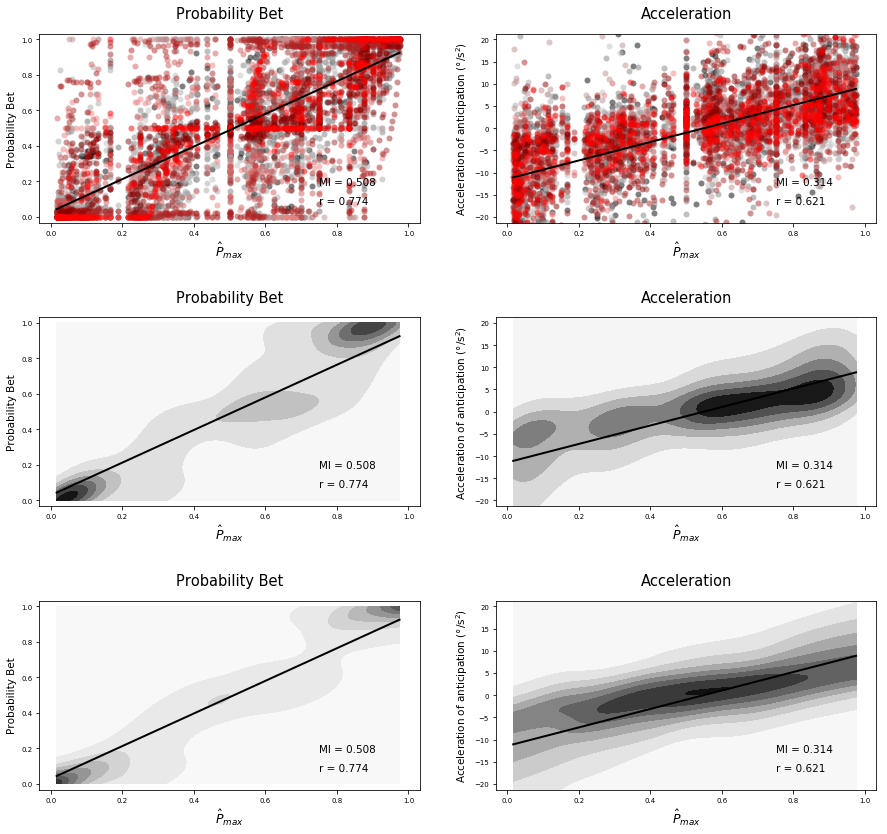

In [11]:
figure(mode='max')

### enregistrement figure

#### kde p_bet

#### kde v_a

#### kde mean p_bet

#### kde mean v_a

# Test beta

In [12]:
from scipy.stats import beta

### Moyenne de la beta distribution pour chaque mode

- la moyenne de la beta distribution sur l'axe y

- la variance est représenté par la taille des scatter (plus le point est gros plus la variance est importante)

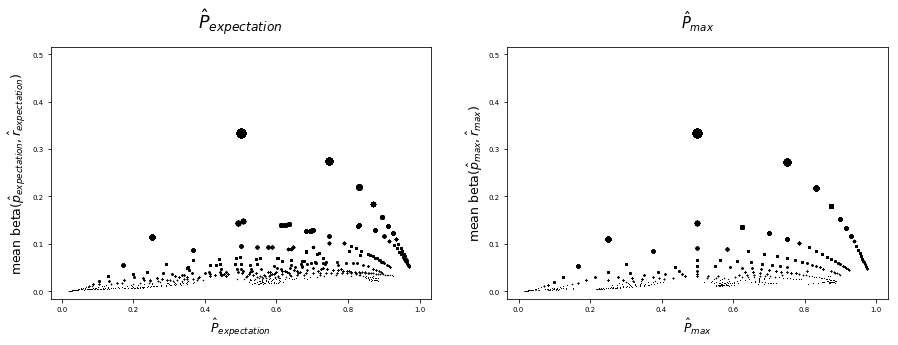

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_width/(1.6180*2)))

gs = gridspec.GridSpec(1, 2)
gs.update(hspace=0.3, wspace=0.2)
for x in range(2):
    axs[x] = plt.subplot(gs[x])

    
for x in range(len(axs)) :
    #----------------------------------------------------------------
    if x == 0 : # expectation
        full_p_hat = full_p_hat_e
        full_r_hat = full_r_hat_e
        axs[x].set_title('$\hat{P}_{expectation}$', fontsize=t_titre, x=0.5, y=1.05)
        axs[x].set_xlabel('$\hat{P}_{expectation}$', fontsize=t_label)
        axs[x].set_ylabel('mean beta($\hat{p}_{expectation}, \hat{r}_{expectation}$)', fontsize=t_label)
        
    elif x == 1 : # max
        full_p_hat = full_p_hat_m
        full_r_hat = full_r_hat_m
        axs[x].set_title('$\hat{P}_{max}$', fontsize=t_titre/1.2, x=0.5, y=1.05)
        axs[x].set_xlabel('$\hat{P}_{max}$', fontsize=t_label)
        axs[x].set_ylabel('mean beta($\hat{p}_{max}, \hat{r}_{max}$)', fontsize=t_label)
        
    #----------------------------------------------------------------
    
    for trial in range(len(full_p_hat)):
        a = full_p_hat[trial]
        b = full_r_hat[trial]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
        axs[x].scatter(full_p_hat[trial], mean, s=(var*1000), c='k', lw=0)
    #----------------------------------------------------------------
    
    axs[x].axis([-0.032, 1.032, -0.016, 0.516])  
    axs[x].xaxis.set_ticks_position('bottom')
    axs[x].yaxis.set_ticks_position('left')
    axs[x].xaxis.set_tick_params(labelsize=t_label/1.8)
    axs[x].yaxis.set_tick_params(labelsize=t_label/1.8)

### Moyenne de la beta distribution pour chaque p$_{bet}$ et V$_a$

- la moyenne de la beta distribution sur l'axe x

- la variance est représenté par la taille des scatter (plus le point est gros plus la variance est importante)

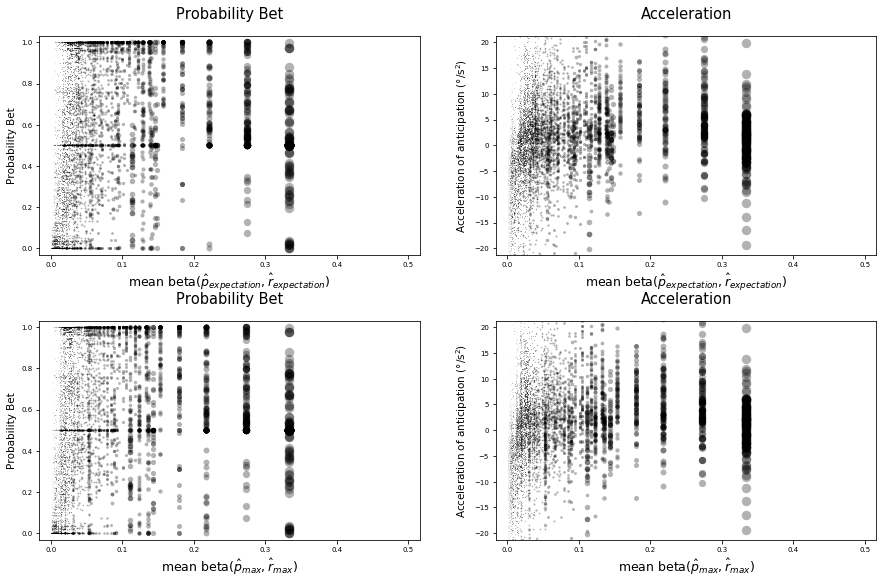

In [14]:
fig, axs = plt.subplots(4, 1, figsize=(fig_width, fig_width/(1.6180)))

gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3, wspace=0.2)
for x in range(4):
    axs[x] = plt.subplot(gs[x])

    
for x in range(len(axs)) :
    #----------------------------------------------------------------
    if x in [0,1] : # expectation
        p_hat_sujet = p_hat_sujet_e
        full_p_hat = full_p_hat_e
        full_r_hat = full_r_hat_e
        axs[x].set_xlabel('mean beta($\hat{p}_{expectation}, \hat{r}_{expectation}$)', fontsize=t_label/1)  
        
    elif x in [2,3] : # max
        p_hat_sujet = p_hat_sujet_m
        full_p_hat = full_p_hat_m
        full_r_hat = full_r_hat_m
        axs[x].set_xlabel('mean beta($\hat{p}_{max}, \hat{r}_{max}$)', fontsize=t_label/1) 
        
    if x in [0,2] : # results
        full = full_results
        axs[x].set_ylabel('Probability Bet', fontsize=t_label/1.2)
        axs[x].set_title("Probability Bet", fontsize=t_titre/1.2, x=0.5, y=1.05)
        y1 = -0.032
        y2 = 1.032
        
    elif x in [1,3]: # va
        full = full_va     
        axs[x].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label/1.2)
        axs[x].set_title("Acceleration", fontsize=t_titre/1.2, x=0.5, y=1.05)
        y1 = -21.28
        y2 = 21.28
        
    #----------------------------------------------------------------
    for trial in range(len(full)):
        a = full_p_hat[trial]
        b = full_r_hat[trial]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
        axs[x].scatter(mean, full[trial], s=(var*1000), alpha=0.3, c='k', lw=0)
    
    #----------------------------------------------------------------
    axs[x].axis([-0.016,0.516,y1, y2])  
    axs[x].xaxis.set_ticks_position('bottom')
    axs[x].yaxis.set_ticks_position('left')
    axs[x].xaxis.set_tick_params(labelsize=t_label/1.8)
    axs[x].yaxis.set_tick_params(labelsize=t_label/1.8)

### Full scatter plot avec beta

- la moyenne de la beta distribution est représenter par la taille de scatter (plus le point est gros plus la moyenne est importante)

- la variance est représenté par la transparence des scatter (plus le point est transparent plus la variance est importante)

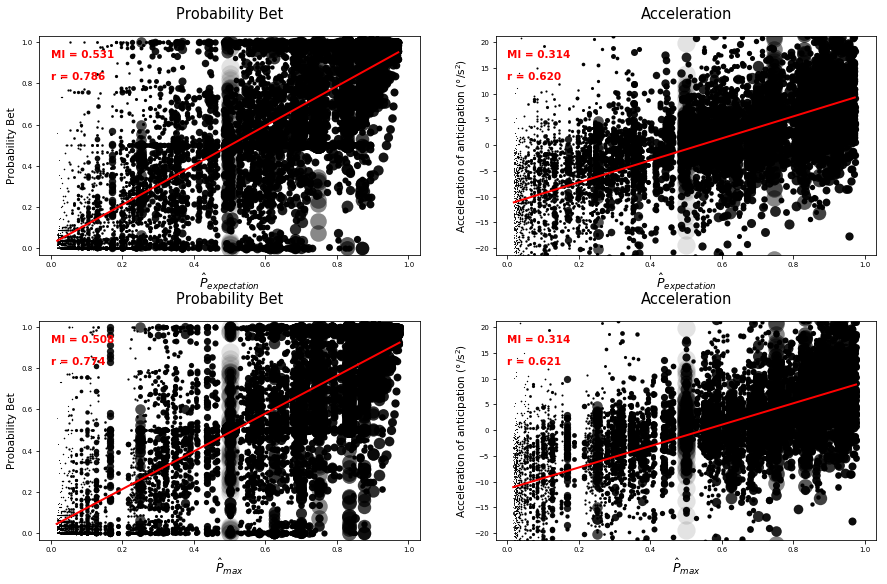

In [15]:
fig, axs = plt.subplots(4, 1, figsize=(fig_width, fig_width/(1.6180)))

gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3, wspace=0.2)
for x in range(4):
    axs[x] = plt.subplot(gs[x])

    
for x in range(len(axs)) :
    #----------------------------------------------------------------
    if x in [0,1] : # expectation
        full_p_hat = full_p_hat_e
        full_r_hat = full_r_hat_e
        axs[x].set_xlabel('$\hat{P}_{expectation}$', fontsize=t_label/1)  
        
    elif x in [2,3] : # max
        full_p_hat = full_p_hat_m
        full_r_hat = full_r_hat_m
        axs[x].set_xlabel('$\hat{P}_{max}$', fontsize=t_label/1) 
        
    if x in [0,2] : # results
        full = full_results
        axs[x].set_ylabel('Probability Bet', fontsize=t_label/1.2)
        axs[x].set_title("Probability Bet", fontsize=t_titre/1.2, x=0.5, y=1.05)
        y1 = -0.032
        y2 = 1.032
        
    elif x in [1,3]: # va
        full = full_va     
        axs[x].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label/1.2)
        axs[x].set_title("Acceleration", fontsize=t_titre/1.2, x=0.5, y=1.05)
        y1 = -21.28
        y2 = 21.28
    #----------------------------------------------------------------
    
    for trial in range(len(full)):
        a = full_p_hat[trial]
        b = full_r_hat[trial]
        mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
        axs[x].scatter(full_p_hat[trial], full[trial], alpha=1-(var*10), s=mean*1000, c='k', lw=0)
    #----------------------------------------------------------------
    
    axs[x].axis([-0.032, 1.032, y1, y2])  
    axs[x].xaxis.set_ticks_position('bottom')
    axs[x].yaxis.set_ticks_position('left')
    axs[x].xaxis.set_tick_params(labelsize=t_label/1.8)
    axs[x].yaxis.set_tick_params(labelsize=t_label/1.8)
    
    full_p_hat_nan = np.ma.masked_array(full_p_hat, mask=np.isnan(full)).compressed()
    full_nan = np.ma.masked_array(full, mask=np.isnan(full)).compressed()

    slope, intercept, r_value, p_value, std_err = stats.linregress(full_p_hat_nan, full_nan)
    x_test = np.linspace(np.min(full_p_hat), np.max(full_p_hat), 100)
    fitLine = slope * x_test + intercept
    axs[x].plot(x_test, fitLine, c='r', linewidth=2)
    axs[x].text(0.0,y1+8*(y2-y1)/10, 'r = %0.3f'%(r_value), color='r', fontsize=t_label/1.2, weight='bold')

    hist, x_edges, y_edges = np.histogram2d(full_p_hat_nan,full_nan,bins=20)
    axs[x].text(0.0,y1+9*(y2-y1)/10, 'MI = %0.3f'%(mutual_information(hist)), color='r', fontsize=t_label/1.2, weight='bold')

### Scatter plot avec beta

- la moyenne de la beta distribution est représenter par la taille de scatter (plus le point est gros plus la moyenne est importante)

- la variance est représenté par la transparence des scatter (plus le point est transparent plus la variance est importante)

- chaque sujet est représenté par une couleur différente

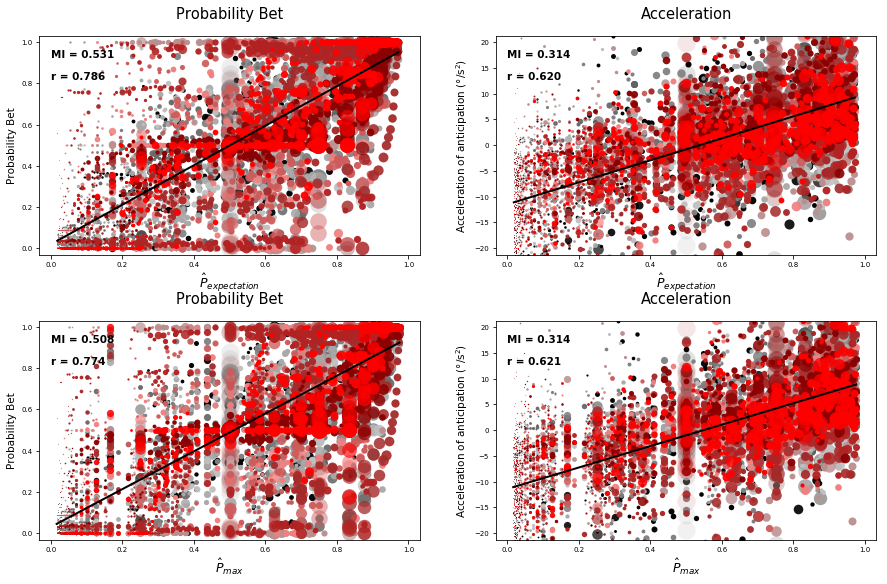

In [16]:
fig, axs = plt.subplots(4, 1, figsize=(fig_width, fig_width/(1.6180)))

gs = gridspec.GridSpec(2, 2)
gs.update(hspace=0.3, wspace=0.2)
for x in range(4):
    axs[x] = plt.subplot(gs[x])

    
for x in range(len(axs)) :
    
    #----------------------------------------------------------------
    if x in [0,1] : # expectation
        p_hat_sujet = p_hat_sujet_e
        r_hat_sujet = r_hat_sujet_e
        full_p_hat = full_p_hat_e
        full_r_hat = full_r_hat_e
        axs[x].set_xlabel('$\hat{P}_{expectation}$', fontsize=t_label/1)  
        
    elif x in [2,3] : # max
        p_hat_sujet = p_hat_sujet_m
        r_hat_sujet = r_hat_sujet_m
        full_p_hat = full_p_hat_m
        full_r_hat = full_r_hat_m
        axs[x].set_xlabel('$\hat{P}_{max}$', fontsize=t_label/1) 
        
    if x in [0,2] : # results
        sujet = results_sujet
        full = full_results
        axs[x].set_ylabel('Probability Bet', fontsize=t_label/1.2)
        axs[x].set_title("Probability Bet", fontsize=t_titre/1.2, x=0.5, y=1.05)
        y1 = -0.032
        y2 = 1.032
        
    elif x in [1,3]: # va
        sujet = va_sujet
        full = full_va     
        axs[x].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label/1.2)
        axs[x].set_title("Acceleration", fontsize=t_titre/1.2, x=0.5, y=1.05)
        y1 = -21.28
        y2 = 21.28
    #----------------------------------------------------------------    
        
    for s, color in enumerate(colors[:nb_sujet]):
        for y in range(len(results_sujet[s])):
            a = p_hat_sujet[s][y]
            b = r_hat_sujet[s][y]
            mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')
            axs[x].scatter(p_hat_sujet[s][y], sujet[s][y], alpha=1-(var*10), s=mean*1000, c=color, lw=0)    
    #----------------------------------------------------------------
    axs[x].axis([-0.032,1.032,y1, y2])  
    axs[x].xaxis.set_ticks_position('bottom')
    axs[x].yaxis.set_ticks_position('left')
    axs[x].xaxis.set_tick_params(labelsize=t_label/1.8)
    axs[x].yaxis.set_tick_params(labelsize=t_label/1.8)
    
    full_p_hat_nan = np.ma.masked_array(full_p_hat, mask=np.isnan(full)).compressed()
    full_nan = np.ma.masked_array(full, mask=np.isnan(full)).compressed()

    slope, intercept, r_value, p_value, std_err = stats.linregress(full_p_hat_nan, full_nan)
    x_test = np.linspace(np.min(full_p_hat), np.max(full_p_hat), 100)
    fitLine = slope * x_test + intercept
    axs[x].plot(x_test, fitLine, c='k', linewidth=2)
    axs[x].text(0.0,y1+8*(y2-y1)/10, 'r = %0.3f'%(r_value), fontsize=t_label/1.2, weight='bold')

    hist, x_edges, y_edges = np.histogram2d(full_p_hat_nan,full_nan,bins=20)
    axs[x].text(0.0,y1+9*(y2-y1)/10, 'MI = %0.3f'%(mutual_information(hist)), fontsize=t_label/1.2, weight='bold')